# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [2]:
SEED = 0

class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()

        input_layer = nn.Linear(no_features, 128)
        input_activation = nn.ReLU()
        input_dropout = nn.Dropout(0.2)
        output = nn.Linear(128, no_labels)
        output_activation = nn.Sigmoid()

        self.mlp_stack = nn.Sequential()
        self.mlp_stack.append(input_layer)
        self.mlp_stack.append(input_activation)
        self.mlp_stack.append(input_dropout)
        
        for i in range(1, no_hidden):
            layer = nn.Linear(128, 128)
            activation = nn.ReLU()
            dropout = nn.Dropout(0.2)
            self.mlp_stack.append(layer)
            self.mlp_stack.append(activation)
            self.mlp_stack.append(dropout)
        self.mlp_stack.append(output)
        self.mlp_stack.append(output_activation)

    def forward(self, x):
        return self.mlp_stack(x)

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # YOUR CODE HERE
    X_train, y_train, X_test, y_test = split_dataset(df, ['label','filename'], 0.3, SEED)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        """
        X: input features dataframe
        y: labels dataframe
        """
        self.features = torch.tensor(X, dtype=torch.float)
        self.labels = torch.tensor(y, dtype=torch.float)
        return

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]



def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size = 256):
    # YOUR CODE HERE
    train_ds = CustomDataset(X_train_scaled, y_train)
    train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
    test_ds = CustomDataset(X_test_scaled, y_test)
    test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [5]:
# YOUR CODE HERE
epochs = 100
lr = 0.001
batch_size = 256
early_stopping = 3
no_features = 77
no_hidden = 3
no_labels = 1
model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
# YOUR CODE HERE

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.reshape(-1, 1))
        optimizer.zero_grad() # initialize gradient calculations
        loss.backward() # compute gradients
        optimizer.step() # execute one step of GD

        train_loss += loss.item()
        train_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))

    train_loss /= size
    train_acc /= size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.reshape(-1, 1)).item()
            test_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))
    model.train()
    test_loss /= size
    test_acc /= size
    return test_loss, test_acc

class EarlyStopper:
    """
    Implements an early stopping check that returns True if the validation loss increases past a minimum delta threshold too many times
    """
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
        if self.counter >= self.patience:
            return True
        return False

train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
early_stopper = EarlyStopper(patience = early_stopping)

for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)
    if early_stopper.early_stop(test_loss):
        break

 14%|█▍        | 14/100 [00:08<00:54,  1.58it/s]


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


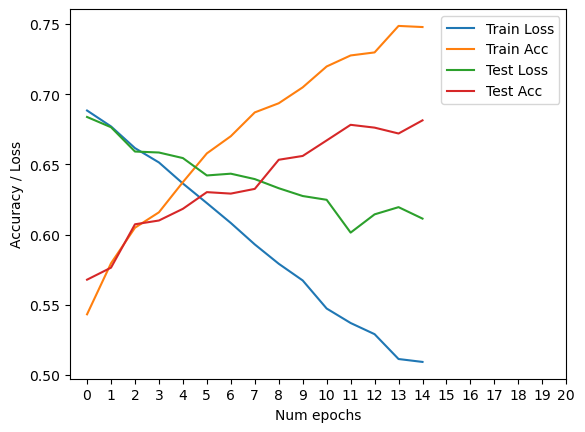

In [7]:
# YOUR CODE HERE
plt.plot(train_loss_, label = "Train Loss")
plt.plot(train_acc_, label = "Train Acc")
plt.plot(test_loss_, label = "Test Loss")
plt.plot(test_acc_, label = "Test Acc")

plt.legend()
plt.xticks(np.arange(0, 21, step=1))
plt.ylabel("Accuracy / Loss")
plt.xlabel("Num epochs")
plt.show()

2. Comment on line plots.

In [8]:
# YOUR CODE HERE
answer = """
From the plot, we can see that firstly, early stopping was invoked after 20 epochs. 
This indicates that the 3-layer DNN was able to capture the complexities in the data after iterating through the dataset just 20 times.
By stopping the training at the point where the loss of the test set starts to increase instead of decrease, we prevent the model from overfitting.
This practice is especially prevalent in the training of DNN where the number of parameters are extremely large, thus making the complex model more 
prone to overfitting and modelling the unwanted random noise in the data.
With regards to performance, we see that as expected, the loss and accuracy for both train and test set move in opposite directions as training progresses.
Specifically, loss decreases as accuracy increases.
"""